## Computer Vision

## PART A

## 1. Import and Understand the data

#### A. Import and read ‘images.npy’.

In [1]:
import numpy as np
data =  np.load('images.npy', allow_pickle=True)

In [2]:
data[10][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.48, 'y': 0.10385756676557864},
   {'x': 0.7716666666666666, 'y': 0.6795252225519288}],
  'imageWidth': 600,
  'imageHeight': 337}]

#### B. Split the data into Features(X) & labels(Y). Unify shape of all the images.

In [3]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

#### C. Split the data into train and test[400:9]

In [4]:
X_train = X[:400]
y_train = masks[:400]

In [5]:
X_test = X[400:]
y_test = masks[400:]

#### D. Select random image from the train data and display original image and masked image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


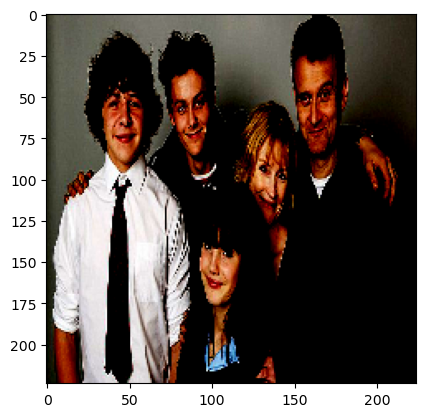

In [6]:
import matplotlib.pyplot as plt

n =6  
plt.imshow(X_train[n])

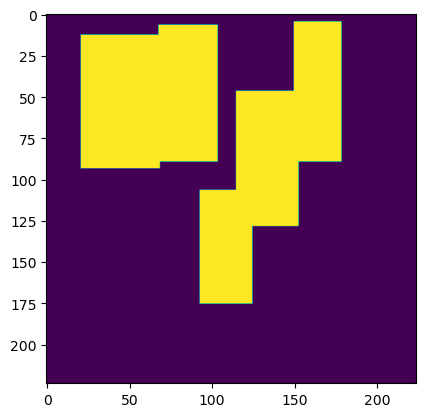

In [7]:
plt.imshow(masks[n])

## 2. Model building

#### A. Design a face mask detection model. 

In [8]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
  
    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)

    return Model(inputs=model.input, outputs=x)

In [9]:
model = create_model()



(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224, 1984)
(None, 224, 224)


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']        

                                                                                                  
 conv_pw_5 (Conv2D)          (None, 28, 28, 256)          65536     ['conv_dw_5_relu[0][0]']      
                                                                                                  
 conv_pw_5_bn (BatchNormali  (None, 28, 28, 256)          1024      ['conv_pw_5[0][0]']           
 zation)                                                                                          
                                                                                                  
 conv_pw_5_relu (ReLU)       (None, 28, 28, 256)          0         ['conv_pw_5_bn[0][0]']        
                                                                                                  
 conv_pad_6 (ZeroPadding2D)  (None, 29, 29, 256)          0         ['conv_pw_5_relu[0][0]']      
                                                                                                  
 conv_dw_6

 conv_pw_10_relu (ReLU)      (None, 14, 14, 512)          0         ['conv_pw_10_bn[0][0]']       
                                                                                                  
 conv_dw_11 (DepthwiseConv2  (None, 14, 14, 512)          4608      ['conv_pw_10_relu[0][0]']     
 D)                                                                                               
                                                                                                  
 conv_dw_11_bn (BatchNormal  (None, 14, 14, 512)          2048      ['conv_dw_11[0][0]']          
 ization)                                                                                         
                                                                                                  
 conv_dw_11_relu (ReLU)      (None, 14, 14, 512)          0         ['conv_dw_11_bn[0][0]']       
                                                                                                  
 conv_pw_1

__________________________________________________________________________________________________


#### B. Design your own Dice Coefficient and Loss function.


In [11]:
from tensorflow import reduce_sum
from tensorflow.keras.backend import epsilon

def dice_coefficient(y_true, y_pred):
    numerator = 2 * reduce_sum(y_true * y_pred)
    denominator = reduce_sum(y_true + y_pred)
    return numerator / (denominator + epsilon())

In [12]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [13]:
model.compile(loss=loss, optimizer='adam', metrics=[dice_coefficient])

In [14]:
model.fit(X_train, y_train, epochs=10, batch_size=1)

Epoch 1/10


400/400 [==============================] - 196s 474ms/step - loss: 1.2987 - dice_coefficient: 0.4963
Epoch 2/10
400/400 [==============================] - 190s 474ms/step - loss: 0.8497 - dice_coefficient: 0.5987
Epoch 3/10
400/400 [==============================] - 190s 474ms/step - loss: 0.7354 - dice_coefficient: 0.6422
Epoch 4/10
400/400 [==============================] - 189s 473ms/step - loss: 0.6679 - dice_coefficient: 0.6682
Epoch 5/10
400/400 [==============================] - 189s 473ms/step - loss: 0.5949 - dice_coefficient: 0.6960
Epoch 6/10
400/400 [==============================] - 189s 472ms/step - loss: 0.5745 - dice_coefficient: 0.7077
Epoch 7/10
400/400 [==============================] - 189s 473ms/step - loss: 0.5250 - dice_coefficient: 0.7275
Epoch 8/10
400/400 [==============================] - 190s 474ms/step - loss: 0.4833 - dice_coefficient: 0.7457
Epoch 9/10
400/400 [==============================] - 189s 471ms/step - loss: 0.4468 - dice_coefficien

#### C. Train and tune the model as required. 

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

#### Fitting the model using below parameters
  - epochs: 10
  - batch_size: 1
  - callbacks: using the callbacks defined above

In [16]:
model.fit(X_train, y_train, epochs=10, batch_size=1, callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.3848 - dice_coefficient: 0.7961
Epoch 1: loss improved from inf to 0.38483, saving model to model-0.38.h5
400/400 [==============================] - 189s 472ms/step - loss: 0.3848 - dice_coefficient: 0.7961 - lr: 0.0010
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.3686 - dice_coefficient: 0.8050
Epoch 2: loss improved from 0.38483 to 0.36859, saving model to model-0.37.h5
400/400 [==============================] - 190s 474ms/step - loss: 0.3686 - dice_coefficient: 0.8050 - lr: 0.0010
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.3751 - dice_coefficient: 0.8022
Epoch 3: loss did not improve from 0.36859
400/400 [==============================] - 189s 472ms/step - loss: 0.3751 - dice_coefficient: 0.8022 - lr: 0.0010
Epoch 4/10
400/400 [==============================] - ETA: 0s - loss: 0.3667 - dice_coefficient: 0.8071
Epoch 4: loss improved from 0.36859 to 0.36668,

#### D. Evaluate and share insights on performance of the model

We can see significant improvement in dice coefficient and very minimal LR on our improved model.

#### 3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


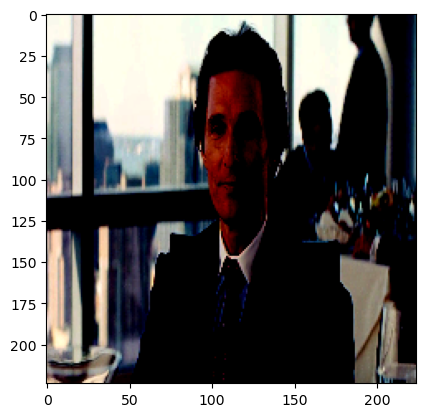

In [17]:
m = 3
plt.imshow(X_test[m])

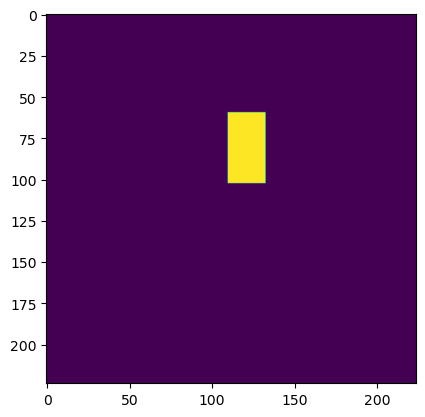

In [18]:
plt.imshow(masks[m])

Predicting the mask on the test image

In [19]:
pred_mask = cv2.resize(1.0 * (model.predict(x=np.array([X_test[m]]))[0] > 0.5), (IMAGE_WIDTH, IMAGE_HEIGHT)) 

1/1 [==============================] - 1s 577ms/step


### Imposing the mask on the test image
- In imshow using the alpha parameter and setting it to 0.9 (i.e. > 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


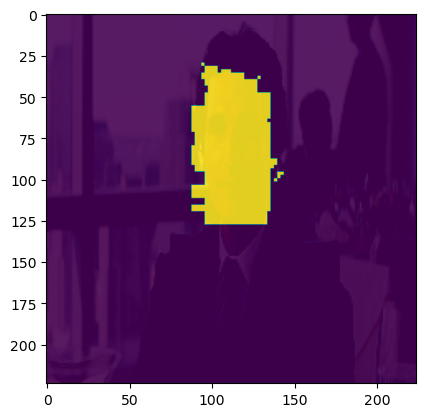

In [20]:
plt.imshow(X_test[m])
plt.imshow(pred_mask, alpha=0.9)

## PART B

In [21]:
import os,cv2,keras,glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm.notebook import trange, tqdm
from IPython.display import Image, display, Markdown, clear_output
from zipfile import ZipFile

### 1. Read/import images from folder ‘training_images’. [2 Marks]

In [22]:
img_dir = "training_images/" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g') # '*' is used to extract all files in the directory
files = glob.glob(data_path)
data = []  # EMPTY LIST
for f1 in files:
    img = cv2.imread(f1)
    data.append(img)

In [23]:
dir_list = next(os.walk(img_dir))[2]
dir_list

['real_00001.jpg',
 'real_00002.jpg',
 'real_00003.jpg',
 'real_00004.jpg',
 'real_00005.jpg',
 'real_00006.jpg',
 'real_00007.jpg',
 'real_00008.jpg',
 'real_00009.jpg',
 'real_00010.jpg',
 'real_00011.jpg',
 'real_00012.jpg',
 'real_00013.jpg',
 'real_00014.jpg',
 'real_00015.jpg',
 'real_00016.jpg',
 'real_00017.jpg',
 'real_00018.jpg',
 'real_00019.jpg',
 'real_00020.jpg',
 'real_00021.jpg',
 'real_00022.jpg',
 'real_00023.jpg',
 'real_00024.jpg',
 'real_00025.jpg',
 'real_00026.jpg',
 'real_00027.jpg',
 'real_00028.jpg',
 'real_00029.jpg',
 'real_00030.jpg',
 'real_00031.jpg',
 'real_00032.jpg',
 'real_00033.jpg',
 'real_00034.jpg',
 'real_00035.jpg',
 'real_00036.jpg',
 'real_00037.jpg',
 'real_00038.jpg',
 'real_00039.jpg',
 'real_00040.jpg',
 'real_00041.jpg',
 'real_00042.jpg',
 'real_00043.jpg',
 'real_00044.jpg',
 'real_00045.jpg',
 'real_00046.jpg',
 'real_00047.jpg',
 'real_00048.jpg',
 'real_00049.jpg',
 'real_00050.jpg',
 'real_00051.jpg',
 'real_00052.jpg',
 'real_00053

In [24]:
x_cord=[]
y_cord=[]
height=[]
width=[]
face_detected=[]
image_name=[]

### 2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images. [3 Marks]

In [26]:
import cv2 

for i in range (len(dir_list)):
    print("Execution loop=",i)
    # Create a cascade classfier object
    face_cascade= cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    data_path = os.path.join(img_dir,dir_list[i])
    img=cv2.imread(data_path)
    faces=face_cascade.detectMultiScale(img,scaleFactor=1.05,minNeighbors=5)

    j=0 

    # Find coordinates of the face
    for x,y,w,h in faces:
        img=cv2.rectangle(img,(x,y),(x+w,y+h),(255, 0, 0),2)
        j=j+1
    resized=cv2.resize(img,(int(img.shape[1]/2),int(img.shape[0])))
    
    length=len(faces)
    if length==0:
        a=0
        b=0
        c=0
        d=0
        j=0
        name=0
        
    else:
        a=faces[0,0]
        b=faces[0,1]
        c=faces[0,2]
        d=faces[0,3]
        name=dir_list[i]
        
    
    x_cord.append(a)
    y_cord.append(b)
    width.append(c)
    height.append(d)
    face_detected.append(j)
    image_name.append(name)

Execution loop= 0
Execution loop= 1
Execution loop= 2
Execution loop= 3
Execution loop= 4
Execution loop= 5
Execution loop= 6
Execution loop= 7
Execution loop= 8
Execution loop= 9
Execution loop= 10
Execution loop= 11
Execution loop= 12
Execution loop= 13
Execution loop= 14
Execution loop= 15
Execution loop= 16
Execution loop= 17
Execution loop= 18
Execution loop= 19
Execution loop= 20
Execution loop= 21
Execution loop= 22
Execution loop= 23
Execution loop= 24
Execution loop= 25
Execution loop= 26
Execution loop= 27
Execution loop= 28
Execution loop= 29
Execution loop= 30
Execution loop= 31
Execution loop= 32
Execution loop= 33
Execution loop= 34
Execution loop= 35
Execution loop= 36
Execution loop= 37
Execution loop= 38
Execution loop= 39
Execution loop= 40
Execution loop= 41
Execution loop= 42
Execution loop= 43
Execution loop= 44
Execution loop= 45
Execution loop= 46
Execution loop= 47
Execution loop= 48
Execution loop= 49
Execution loop= 50
Execution loop= 51
Execution loop= 52
Exe

Execution loop= 417
Execution loop= 418
Execution loop= 419
Execution loop= 420
Execution loop= 421
Execution loop= 422
Execution loop= 423
Execution loop= 424
Execution loop= 425
Execution loop= 426
Execution loop= 427
Execution loop= 428
Execution loop= 429
Execution loop= 430
Execution loop= 431
Execution loop= 432
Execution loop= 433
Execution loop= 434
Execution loop= 435
Execution loop= 436
Execution loop= 437
Execution loop= 438
Execution loop= 439
Execution loop= 440
Execution loop= 441
Execution loop= 442
Execution loop= 443
Execution loop= 444
Execution loop= 445
Execution loop= 446
Execution loop= 447
Execution loop= 448
Execution loop= 449
Execution loop= 450
Execution loop= 451
Execution loop= 452
Execution loop= 453
Execution loop= 454
Execution loop= 455
Execution loop= 456
Execution loop= 457
Execution loop= 458
Execution loop= 459
Execution loop= 460
Execution loop= 461
Execution loop= 462
Execution loop= 463
Execution loop= 464
Execution loop= 465
Execution loop= 466


Execution loop= 827
Execution loop= 828
Execution loop= 829
Execution loop= 830
Execution loop= 831
Execution loop= 832
Execution loop= 833
Execution loop= 834
Execution loop= 835
Execution loop= 836
Execution loop= 837
Execution loop= 838
Execution loop= 839
Execution loop= 840
Execution loop= 841
Execution loop= 842
Execution loop= 843
Execution loop= 844
Execution loop= 845
Execution loop= 846
Execution loop= 847
Execution loop= 848
Execution loop= 849
Execution loop= 850
Execution loop= 851
Execution loop= 852
Execution loop= 853
Execution loop= 854
Execution loop= 855
Execution loop= 856
Execution loop= 857
Execution loop= 858
Execution loop= 859
Execution loop= 860
Execution loop= 861
Execution loop= 862
Execution loop= 863
Execution loop= 864
Execution loop= 865
Execution loop= 866
Execution loop= 867
Execution loop= 868
Execution loop= 869
Execution loop= 870
Execution loop= 871
Execution loop= 872
Execution loop= 873
Execution loop= 874
Execution loop= 875
Execution loop= 876


### 3. From the same loop above, extract metadata of the faces and write into a DataFrame. [3 Marks

In [27]:
import pandas as pd

DB = pd.DataFrame(x_cord, columns = ['x'])

DB['y']=y_cord
DB['w']=width
DB['h']=height
DB['Total_Faces']=face_detected
DB['Image_Name']=image_name

DB.head()

,x,y,w,h,Total_Faces,Image_Name
0,156,147,419,419,1,real_00001.jpg
1,81,141,434,434,1,real_00002.jpg
2,262,13,125,125,2,real_00003.jpg
3,130,169,362,362,1,real_00004.jpg
4,60,202,332,332,1,real_00005.jpg


### 4. Save the output Dataframe in .csv format. [2 Marks]

In [28]:
DB.to_csv("Bounding boxes.csv")

## PART C

### 1. Unzip, read and Load data(‘PINS.zip’) into session. [2 Marks

In [29]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('PINS')

### 2. Write function to create metadata of the image. 

In [30]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

### 3. Write a loop to iterate through each and every image and create metadata for all the images

In [31]:
# Load an image
# for example, loading the image with index 0
load_image(metadata[0].image_path())

array([[[233, 188, 165],
        [231, 186, 163],
        [220, 178, 156],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       [[232, 187, 164],
        [233, 188, 165],
        [220, 178, 156],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       [[230, 186, 161],
        [228, 184, 159],
        [206, 164, 140],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       ...,

       [[198, 118,  91],
        [197, 120,  94],
        [195, 119,  95],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]],

       [[200, 120,  93],
        [200, 120,  93],
        [198, 121,  95],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]],

       [[201, 121,  94],
        [201, 121,  94],
        [199, 122,  96],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]]

### 4. Generate Embeddings vectors on the each face in the dataset

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [33]:
from tensorflow.keras.models import model_from_json
model = vgg_face()
model.load_weights('vgg_face_weights.h5')

In [34]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [35]:
def embeddor(metadata):# Get embedding vector for first image in the metadata using the pre-trained model

    img_path = metadata[0].image_path()
    img = load_image(img_path)

    # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)

    img = cv2.resize(img, dsize = (224,224))
    print(img.shape)

    # Obtain embedding vector for an image
    # Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    print(embedding_vector.shape)

In [36]:
embeddings = np.zeros((metadata.shape[0], 2622))
k = 0
for i, m in enumerate(metadata):
    try:
        img = load_image(m.image_path())
        if k % 500 == 0:
            print(k)
        # scale RGB values to interval [0,1]
        img = cv2.resize(img, dsize = (224,224))
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
        k += 1
    except Exception as e:
        print(str(e))
        print(i,m)

0
1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 302ms/step
500
1/1 [==============================] - 0s 309ms/step


1/1 [==============================] - 0s 320ms/step


1/1 [==============================] - 0s 324ms/step
1000
1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 301ms/step
1500
1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 300ms/step
2000
1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 325ms/step
2500
1/1 [==============================] - 0s 328ms/step


1/1 [==============================] - 0s 324ms/step
3000
1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 306ms/step
3500
1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 302ms/step
4000
1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 301ms/step
4500
1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 308ms/step


1/1 [==============================] - 0s 318ms/step
5000
1/1 [==============================] - 0s 311ms/step


1/1 [==============================] - 0s 315ms/step
5500
1/1 [==============================] - 0s 310ms/step


1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 306ms/step
6000
1/1 [==============================] - 0s 306ms/step


1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 302ms/step
6500
1/1 [==============================] - 0s 330ms/step


1/1 [==============================] - 0s 304ms/step
7000
1/1 [==============================] - 0s 304ms/step


1/1 [==============================] - 0s 313ms/step


1/1 [==============================] - 0s 306ms/step
7500
1/1 [==============================] - 0s 318ms/step


1/1 [==============================] - 0s 309ms/step
8000
1/1 [==============================] - 0s 311ms/step


1/1 [==============================] - 0s 319ms/step


1/1 [==============================] - 0s 309ms/step
8500
1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 313ms/step


1/1 [==============================] - 0s 317ms/step
9000
1/1 [==============================] - 0s 306ms/step


1/1 [==============================] - 0s 302ms/step
9500
1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 313ms/step


1/1 [==============================] - 0s 344ms/step
10000
1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 303ms/step
10500
1/1 [==============================] - 0s 322ms/step


### 5. Build distance metrics for identifying the distance between two similar and dissimilar images

In [37]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

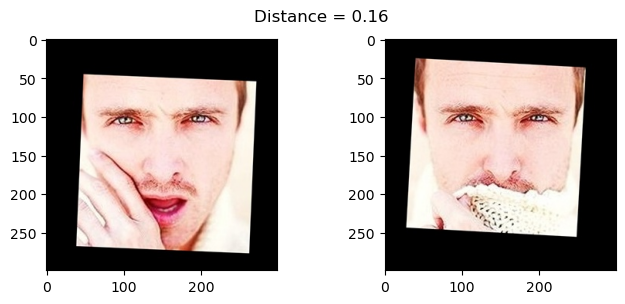

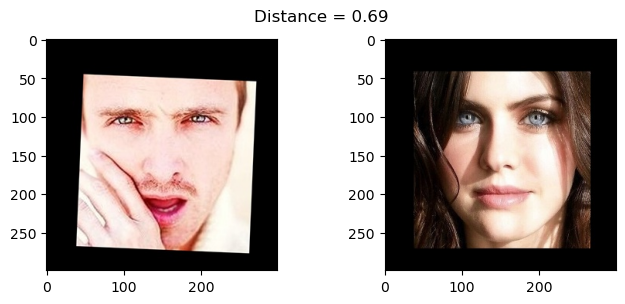

In [38]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

In [39]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

In [40]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Numerical encoding of identities
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [41]:
# Standarize features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### 6. Use PCA for dimensionality reduction. 

In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128, svd_solver='randomized', whiten=True)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

### 7. Build an SVM classifier in order to map each image to its right person.

In [43]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf', class_weight=None , C=10000000, gamma='auto')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9632414369256475

### 8. Import and display the the test images. 

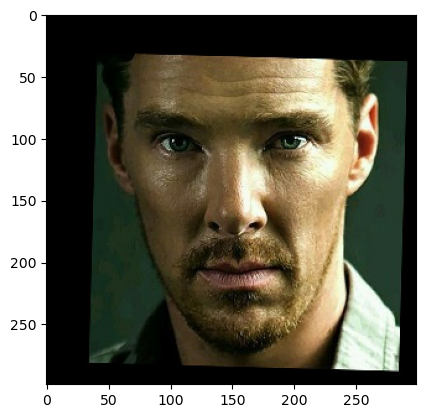

In [44]:
import matplotlib.image as img 
image1 = img.imread(r'C:\Users\soham\AI ML\computer vision\test\test_images\Benedict Cumberbatch9.jpg') 
plt.imshow(image1) 

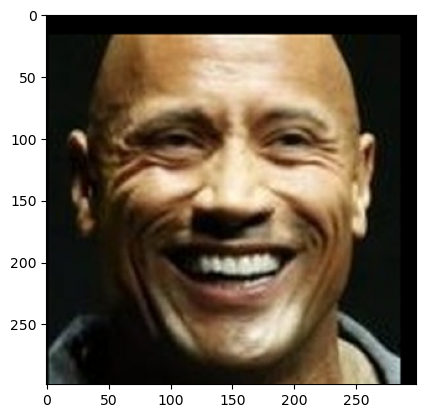

In [45]:
image2 = img.imread(r'C:\Users\soham\AI ML\computer vision\test\test_images\Dwayne Johnson4.jpg') 
plt.imshow(image2) 

In [46]:
metadata_test = load_metadata('test')

In [47]:
embeddings_test = np.zeros((metadata_test.shape[0], 2622))
k = 0
for i, m in enumerate(metadata_test):
    try:
        img = load_image(m.image_path())
        if k % 500 == 0:
            print(k)
        # scale RGB values to interval [0,1]
        img = cv2.resize(img, dsize = (224,224))
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embeddings_test[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
        k += 1
    except Exception as e:
        print(str(e))
        print(i,m)

0
1/1 [==============================] - 0s 298ms/step


In [48]:
predict_idx = [0,1]
targets = embeddings_test[predict_idx]
predict_image = sc.transform(targets)
predict_image = pca.transform(predict_image)

In [49]:
predict_image

array([[-1.11760025,  0.25279623, -0.15721997,  0.32413036, -0.93431027,
        -1.19419293,  0.07511804, -0.60054936, -0.12632073,  0.59585895,
        -0.01385015, -1.0145273 ,  0.21602862, -0.6135958 ,  1.14264343,
         0.6492473 , -0.79218502, -1.60427114, -0.73411868,  0.33286932,
         0.01559219, -0.84112495, -0.20358032,  0.12213489,  0.49394333,
        -0.50123561,  0.05096907, -1.59016539,  1.10727491,  0.33143662,
         0.5626741 ,  0.83340604,  0.50878393, -0.44762284,  2.48171418,
         0.49405123,  0.19550398,  1.58884158, -1.94360332, -0.18322321,
         0.24866501, -0.35547124,  1.02200255, -2.00416284,  0.55816197,
         0.11728514,  0.52115101,  1.14878924,  0.22730075, -0.22400182,
         0.16316867, -0.51745964, -0.77598658, -0.46832266, -0.48607975,
         0.36873365, -0.27964072, -0.91986975, -1.71355973,  0.64376173,
        -0.01318116, -0.85535005, -0.65312145,  0.53383767,  0.72224409,
         0.67300136, -1.16958036, -0.94561271,  0.5

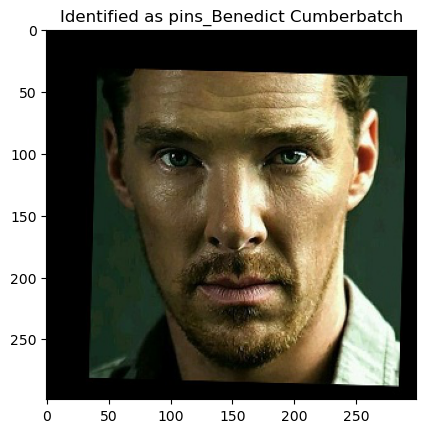

In [50]:
prediction = clf.predict([predict_image[0]])
identity = encoder.inverse_transform(prediction)[0]
plt.imshow(image1)
plt.title(f'Identified as {identity}');

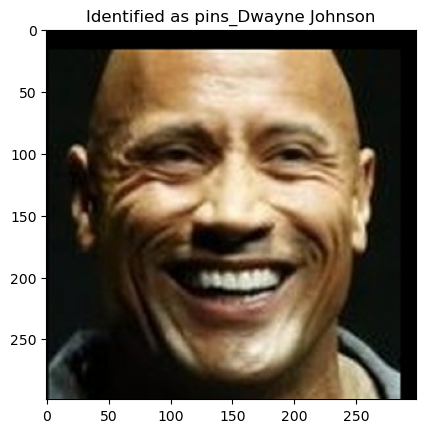

In [51]:
prediction = clf.predict([predict_image[1]])
identity = encoder.inverse_transform(prediction)[0]
plt.imshow(image2)
plt.title(f'Identified as {identity}');